- [1] 모듈 로딩 <hr>

In [14]:
### ===> Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [15]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


- [2] 데이터 준비 <hr>

In [16]:
### ===>  데이터 추출 관련 변수
BATCH_SIZE = 32
EPOCHS = 10

In [17]:
### ===> CIFAR10 데이터 다운로드 (Train set, Test set 분리하기)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,         # 매개변수가 True면 Train False면 Test 이다.
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [18]:
### ===>  데이터 확인하기 (1)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
# X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor  [배치 사이즈, 채널, 높이, 너비]
# y_train: torch.Size([32]) type: torch.LongTensor              [배치사이즈]  즉, 32개 이미지에 대한 라벨

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])


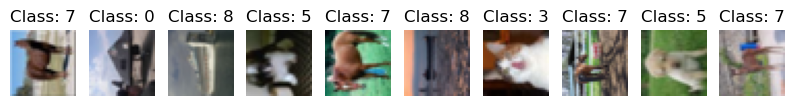

In [26]:
### ===>  데이터 확인하기 (2) 
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    print(np.transpose(X_train[i]).shape)
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    # plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    
    plt.imshow(np.transpose(X_train[i]))
    plt.title('Class: ' + str(y_train[i].item()))

- [3] 모델 설계 <hr>

In [20]:
### ===>  Convolutional Neural Network (CNN) 모델 설계하기

# X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor  [배치 사이즈, 채널, 높이, 너비]
# y_train: torch.Size([32]) type: torch.LongTensor              [배치사이즈]  즉, 32개 이미지에 대한 라벨
# 커널 = 필터 = 마스크
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
                                       # 채널 수          커널수         커널 사이즈, 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)    # 차원을 변경함
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

- [4] 학습 준비 <hr>

In [21]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


C:\Users\kdp\AppData\Local\Temp\ipykernel_17140\2063509333.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


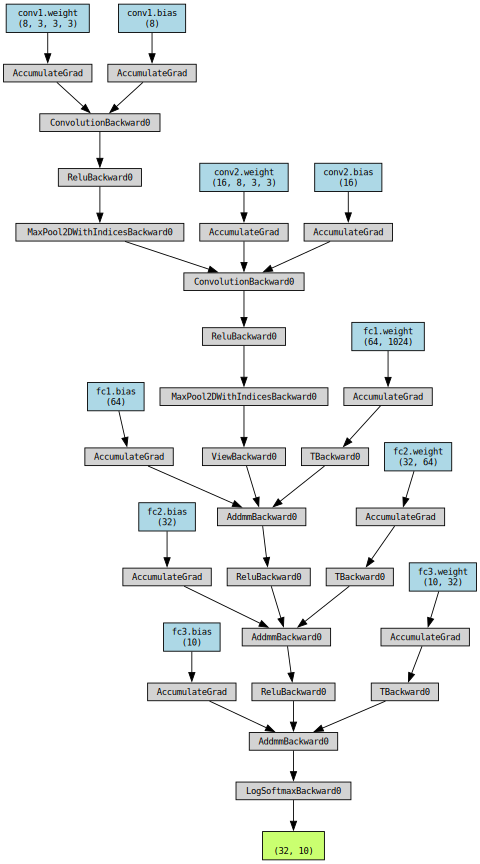

In [22]:
from torchviz import make_dot
make_dot(model(X_train), params = dict(model.named_parameters()))

In [23]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [24]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- [5] 학습진행 <hr>

In [25]:
### ===> CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

C:\Users\kdp\AppData\Local\Temp\ipykernel_17140\2063509333.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0]	Train Loss: 2.343666
Train Epoch: 1 [200]	Train Loss: 2.077966
Train Epoch: 1 [400]	Train Loss: 1.576098
Train Epoch: 1 [600]	Train Loss: 1.540536
Train Epoch: 1 [800]	Train Loss: 1.398309
Train Epoch: 1 [1000]	Train Loss: 1.386464
Train Epoch: 1 [1200]	Train Loss: 1.548434
Train Epoch: 1 [1400]	Train Loss: 1.542249

[EPOCH: 1], 	Test Loss: 0.0440, 	Test Accuracy: 48.47 % 

Train Epoch: 2 [0]	Train Loss: 1.392481
Train Epoch: 2 [200]	Train Loss: 1.391392
Train Epoch: 2 [400]	Train Loss: 1.427457
Train Epoch: 2 [600]	Train Loss: 1.480665
Train Epoch: 2 [800]	Train Loss: 1.617634
Train Epoch: 2 [1000]	Train Loss: 1.379271
Train Epoch: 2 [1200]	Train Loss: 1.434160
Train Epoch: 2 [1400]	Train Loss: 1.150383

[EPOCH: 2], 	Test Loss: 0.0406, 	Test Accuracy: 53.36 % 

Train Epoch: 3 [0]	Train Loss: 1.150271
Train Epoch: 3 [200]	Train Loss: 1.579466
Train Epoch: 3 [400]	Train Loss: 1.101339
Train Epoch: 3 [600]	Train Loss: 1.214850
Train Epoch: 3 [800]	Train Loss: 1.120018
